# Fitting an imperfect model

This notebook explores the *1d* problem of fitting a stellar spectrum where the continuum is wrong but the lines are right.

In [118]:
import numpy as np

from astropy import units as u
from astropy import constants
from astropy.modeling import models, fitting


%matplotlib inline
from matplotlib import pyplot as plt

from astropy.visualization import quantity_support
quantity_support();

In [9]:
spec_wl = np.linspace(3500,9000,4096)*u.angstrom

fluxunits = u.Unit('erg / (cm ** 2 * s * AA * sr)')

In [10]:
continuum1 = models.BlackBody(temperature=5800*u.K, scale=1*fluxunits)
continuum2 = models.BlackBody(temperature=5200*u.K, scale=1*fluxunits)
continuum3 = models.BlackBody(temperature=6400*u.K, scale=1*fluxunits)

# same peak flux of 1
for c in [continuum1, continuum2, continuum3]:
    c.scale = 1/c(c.lambda_max).value

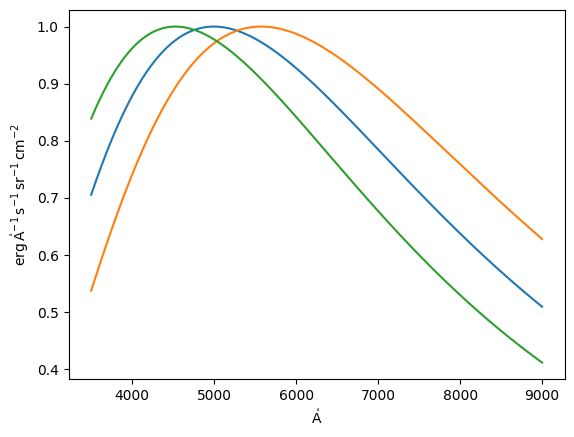

In [11]:
for c in [continuum1, continuum2, continuum3]:
    plt.plot(spec_wl, c(spec_wl))

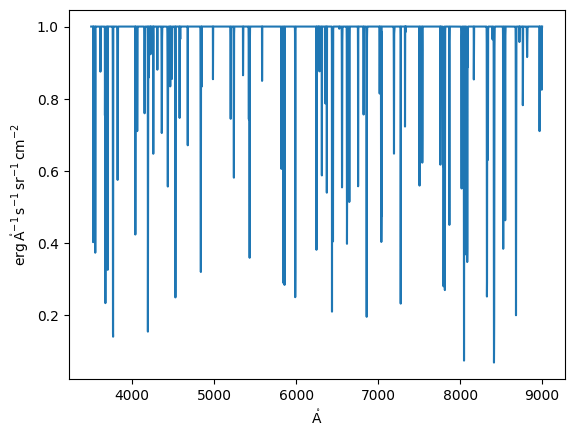

In [12]:
n_lines = 100

lines_ampl = np.random.rand(n_lines)
lines_wl = np.random.rand(n_lines)*np.ptp(spec_wl) + np.min(spec_wl)
lines_sig= np.random.rand(n_lines)*2*u.angstrom

line_models = [models.Gaussian1D(*ps) for ps in zip(lines_ampl, lines_wl, lines_sig)]

lines_flux = np.ones_like(continuum1(spec_wl))
for line in line_models:
    lines_flux *= 1 - line(spec_wl)
plt.plot(spec_wl, lines_flux)

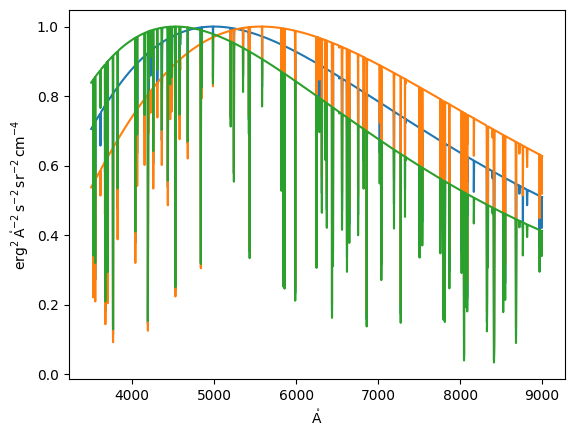

In [13]:
spec1 = continuum1(spec_wl)*lines_flux
spec2 = continuum2(spec_wl)*lines_flux
spec3 = continuum3(spec_wl)*lines_flux

for s in [spec1, spec2, spec3]:
    plt.plot(spec_wl, s)

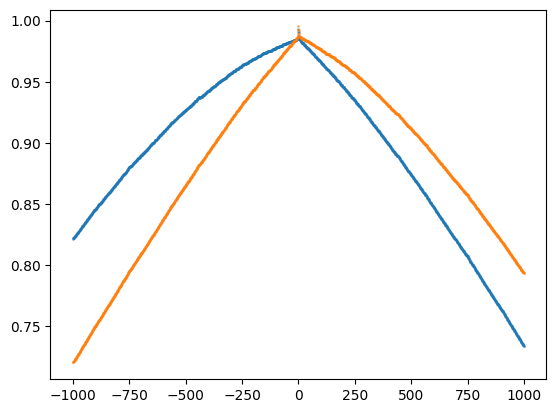

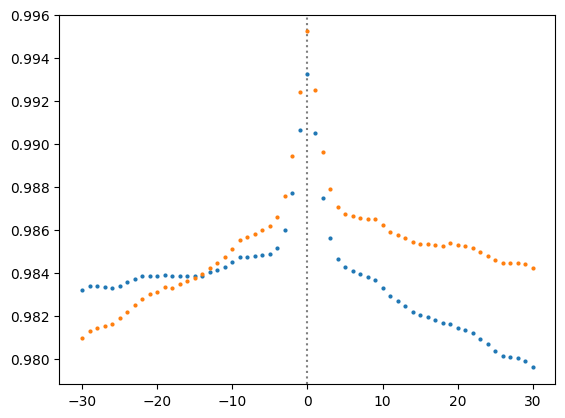

In [14]:
plt.xcorr(spec1, spec2, maxlags=1000, usevlines=False, color='C0', alpha=.5, ms=1);
plt.xcorr(spec1, spec3, maxlags=1000, usevlines=False, color='C1', alpha=.5, ms=1);

plt.figure()
plt.axvline(0, c='k', ls=':', alpha=.5)
plt.xcorr(spec1, spec2, maxlags=30, usevlines=False, color='C0', ms=2);
plt.xcorr(spec1, spec3, maxlags=30, usevlines=False, color='C1', ms=2);

In [88]:
def xcorr_partial(f, g, lags, start, end, normed=True, detrend=None):
    lags = np.asarray(lags)
    if (np.min(lags) + start) < 0:
        raise ValueError('lags fall off of start!')
    if (np.max(lags) + end) > min(len(g), len(f)):
        raise ValueError('lags fall off of end!')
    
    if detrend is not None:
        f = detrend(f)
        g = detrend(g)
    
    xcorr = [np.sum(f[start:end]*g[(start + l):(end + l)]) for l in lags]
    xcorr = xcorr[0].__class__(xcorr)
        
    if normed:
        msk = slice(start, end)
        xcorr = xcorr/np.sqrt(np.dot(f[msk], f[msk]) * np.dot(g[msk], g[msk]))
    
    return xcorr

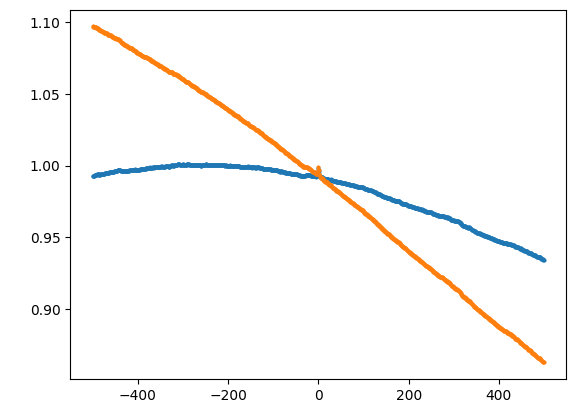

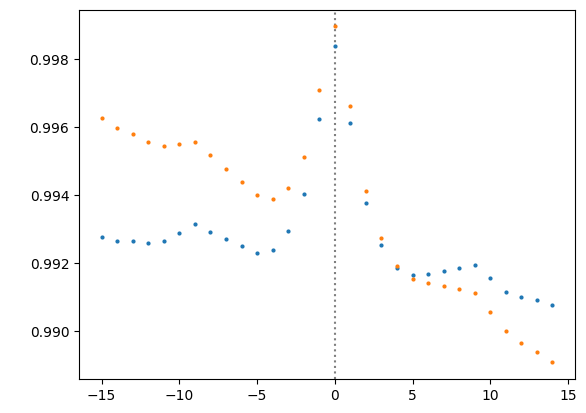

In [89]:
lags = np.arange(1000)-500
plt.plot(lags, xcorr_partial(spec1, spec2, lags, 1024, 1024*3), 'o', ms=2);
plt.plot(lags, xcorr_partial(spec1, spec3, lags, 1024, 1024*3), 'o', ms=2);


plt.figure()
lags = np.arange(30)-15
plt.axvline(0, c='k', ls=':', alpha=.5)
plt.plot(lags, xcorr_partial(spec1, spec2, lags, 1024, 1024*3), 'o', ms=2);
plt.plot(lags, xcorr_partial(spec1, spec3, lags, 1024, 1024*3), 'o', ms=2);

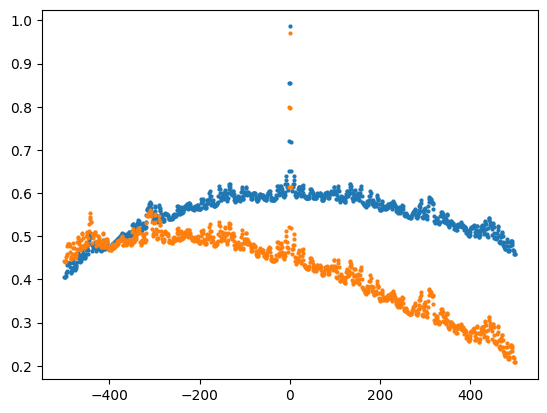

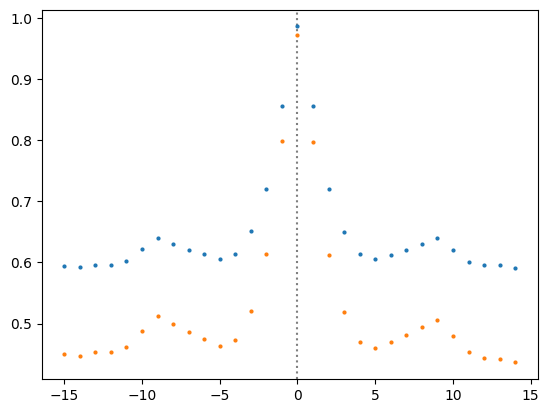

In [91]:
dtf = plt.mlab.detrend_linear

lags = np.arange(1000)-500
plt.plot(lags, xcorr_partial(spec1, spec2, lags, 1024, 1024*3, detrend=dtf), 'o', ms=2);
plt.plot(lags, xcorr_partial(spec1, spec3, lags, 1024, 1024*3, detrend=dtf), 'o', ms=2);


plt.figure()
lags = np.arange(30)-15
plt.axvline(0, c='k', ls=':', alpha=.5)
plt.plot(lags, xcorr_partial(spec1, spec2, lags, 1024, 1024*3, detrend=dtf), 'o', ms=2);
plt.plot(lags, xcorr_partial(spec1, spec3, lags, 1024, 1024*3, detrend=dtf), 'o', ms=2);

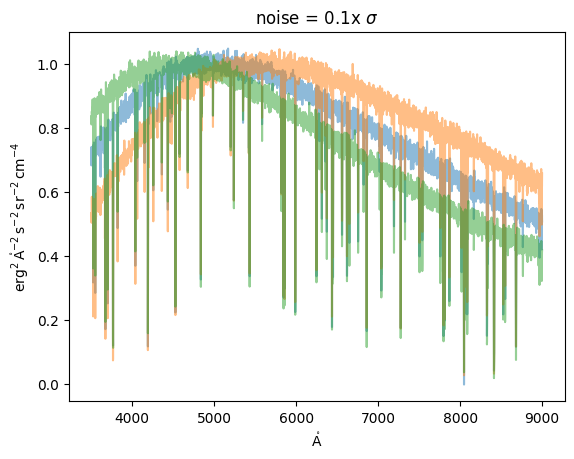

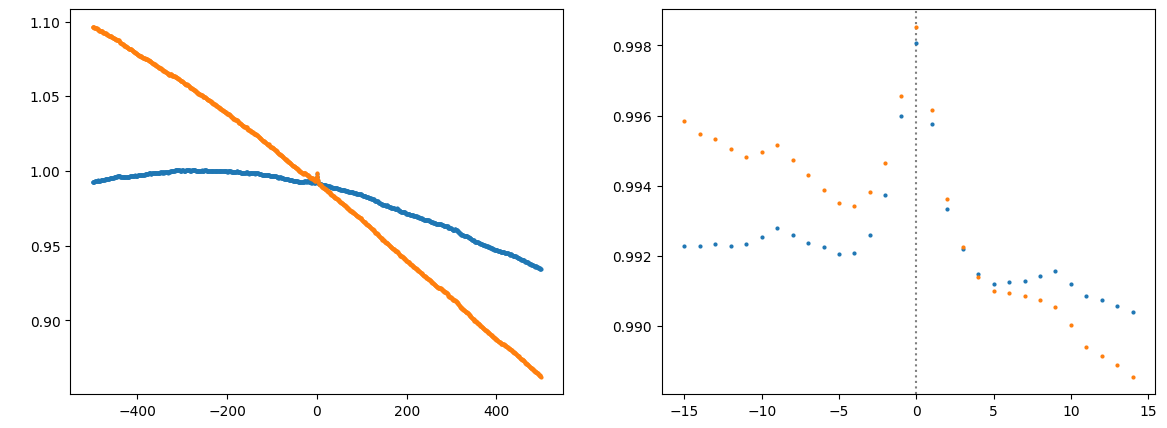

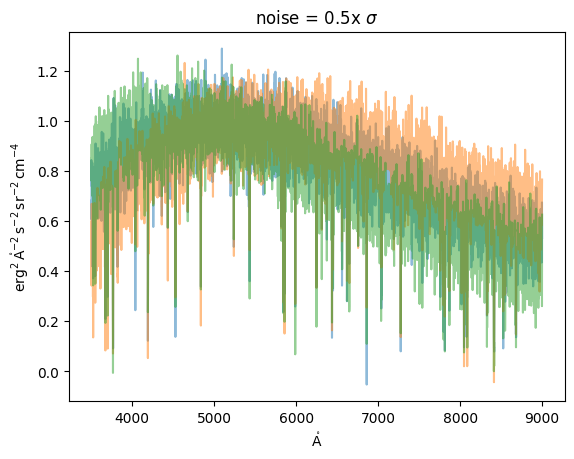

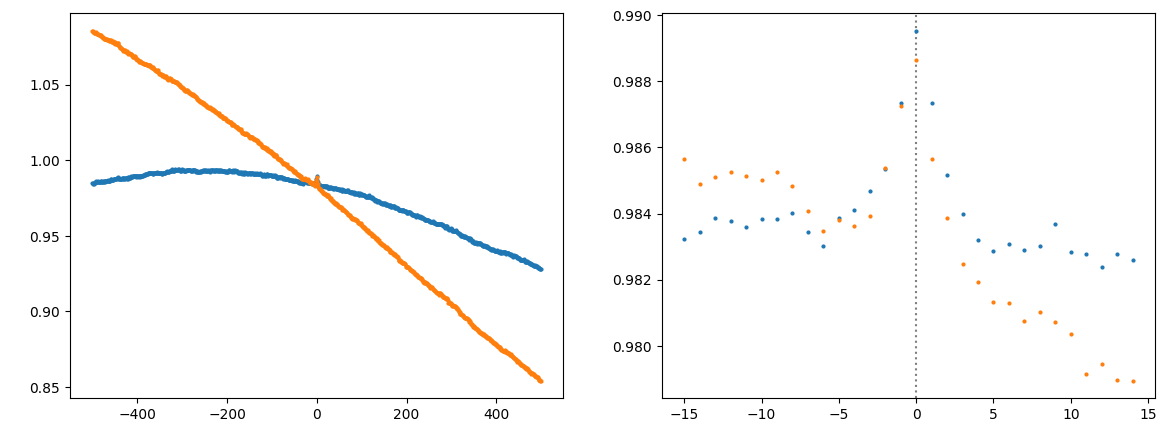

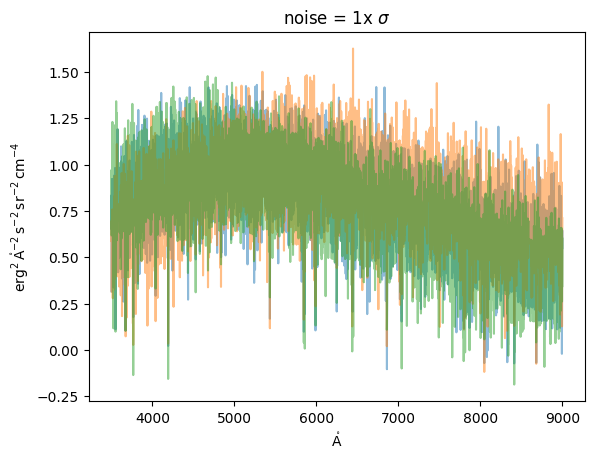

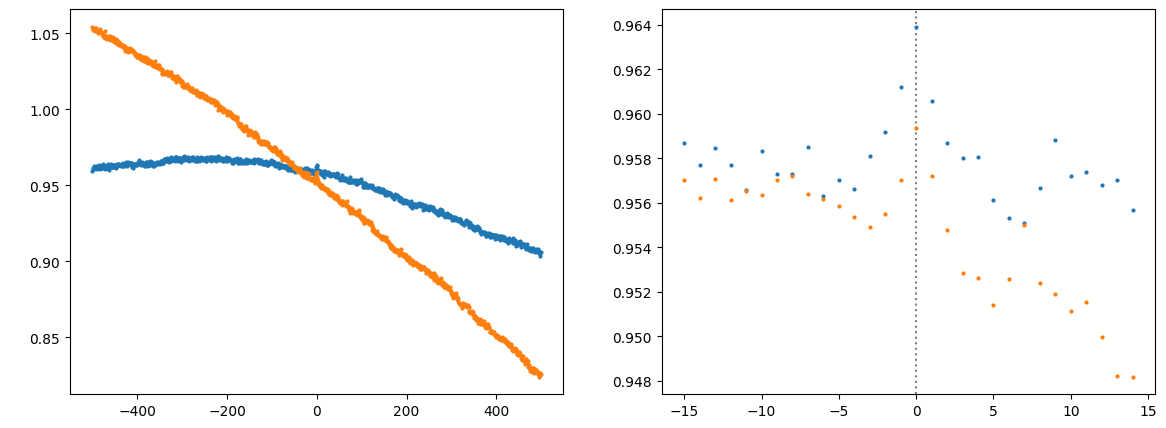

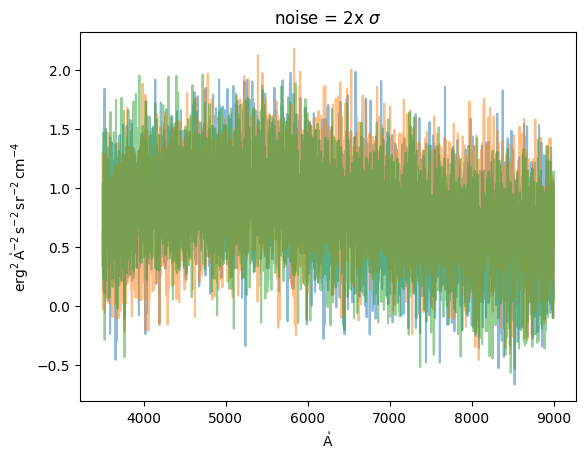

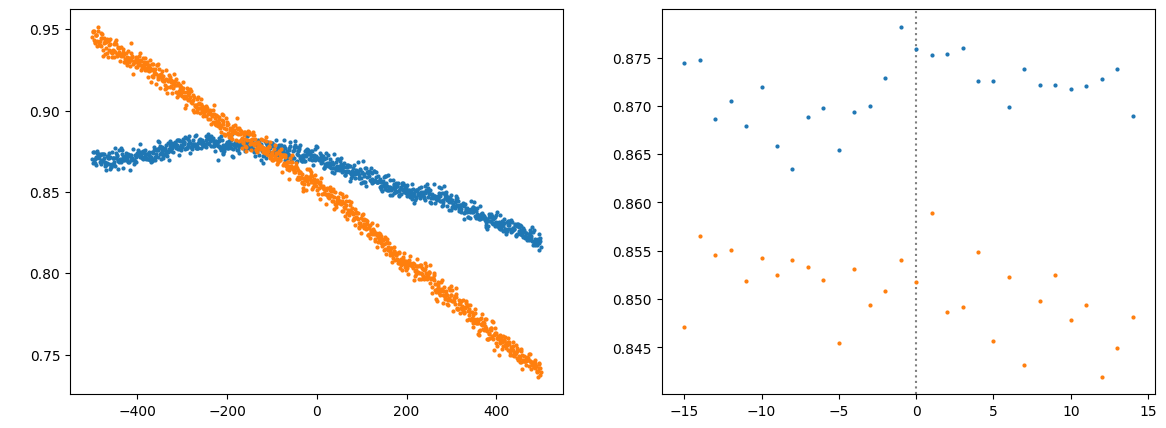

In [98]:
for ascale in [ .1, .5, 1, 2]:
    noise_amplitude = ascale * np.std(spec1)
    plt.figure()
    plt.plot(spec_wl, spec1 + np.random.randn(len(spec1))*noise_amplitude, alpha=.5)
    plt.plot(spec_wl, spec2 + np.random.randn(len(spec1))*noise_amplitude, alpha=.5)
    plt.plot(spec_wl, spec3 + np.random.randn(len(spec1))*noise_amplitude, alpha=.5)
    plt.title(f'noise = {ascale}x $\sigma$')


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    lags = np.arange(1000)-500
    ax1.plot(lags, xcorr_partial(spec1 + np.random.randn(len(spec1))*noise_amplitude, 
                                 spec2 + np.random.randn(len(spec1))*noise_amplitude, 
                                 lags, 1024, 1024*3), 'o', ms=2);
    ax1.plot(lags, xcorr_partial(spec1 + np.random.randn(len(spec1))*noise_amplitude, 
                                 spec3 + np.random.randn(len(spec1))*noise_amplitude, 
                                 lags, 1024, 1024*3), 'o', ms=2);


    lags = np.arange(30)-15
    ax2.axvline(0, c='k', ls=':', alpha=.5)
    ax2.plot(lags, xcorr_partial(spec1 + np.random.randn(len(spec1))*noise_amplitude, 
                                 spec2 + np.random.randn(len(spec1))*noise_amplitude, 
                                 lags, 1024, 1024*3), 'o', ms=2);
    ax2.plot(lags, xcorr_partial(spec1 + np.random.randn(len(spec1))*noise_amplitude, 
                                 spec3 + np.random.randn(len(spec1))*noise_amplitude, 
                                 lags, 1024, 1024*3), 'o', ms=2);

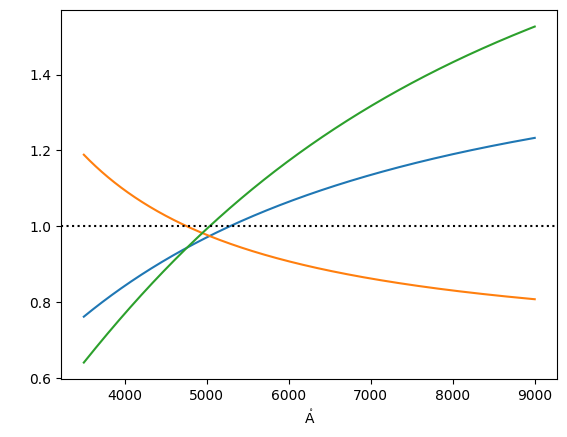

In [104]:
plt.plot(spec_wl, spec2/spec1)
plt.plot(spec_wl, spec3/spec1)
plt.plot(spec_wl, spec2/spec3)
plt.axhline(1, c='k', ls=':')

In [115]:
continuum2.temperature/continuum1.temperature, continuum1.temperature/continuum2.temperature

(<Quantity 0.89655172>, <Quantity 1.11538462>)

In [116]:
continuum3.temperature/continuum1.temperature, continuum1.temperature/continuum3.temperature

(<Quantity 1.10344828>, <Quantity 0.90625>)

In [117]:
continuum2.temperature/continuum3.temperature, continuum3.temperature/continuum2.temperature

(<Quantity 0.8125>, <Quantity 1.23076923>)

<Quantity 0.01438777 K m>

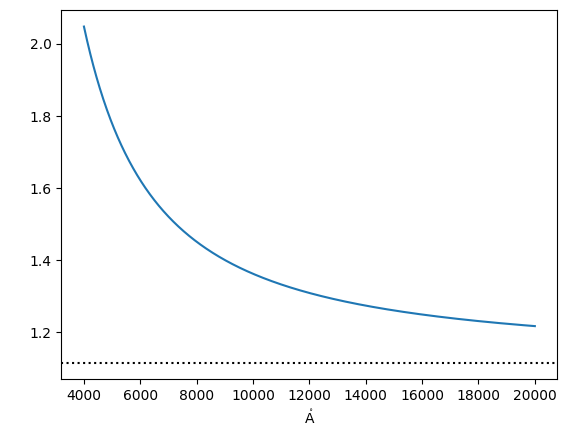

In [132]:
def pratio(lamb, T1, T2):
    hcok = constants.h * constants.c/constants.k_B
    b1 = np.exp(hcok/(lamb*T1)) - 1
    b2 = np.exp(hcok/(lamb*T2)) - 1
    return b1/b2

ww = np.linspace(4000, 20000,1000)*u.angstrom
plt.plot(ww, pratio(ww, 5200*u.K, 5800*u.K))
plt.axhline(5800/5200, c='k', ls=':')

In [ ]:
plt.plot()